## [1] Setup e Import

In [2]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import asyncio
import json

# path del server MCP
sys.path.insert(0, str(Path.cwd().parent / 'mcp_server'))

## [2] Caricamento Dati

Il dataset contiene:
- **Users**: 20 utenti
- **Items**: 30 items (ID: 101-203)
- **Ratings**: ~500 ratings (scala 1-5)

In [3]:
# Carica il dataset
data_path = Path.cwd().parent / 'data' / 'ratings.csv'
df = pd.read_csv(data_path)

print(f" Dataset caricato: {len(df)} ratings")
print(f"   Utenti unici: {df['user_id'].nunique()}")
print(f"   Items unici: {df['item_id'].nunique()}")
print(f"   Rating medio: {df['rating'].mean():.2f}")
print("\n Prime 10 righe:")
df.head(10)

 Dataset caricato: 401 ratings
   Utenti unici: 20
   Items unici: 87
   Rating medio: 4.07

 Prime 10 righe:


,user_id,item_id,rating
0,17,189,4.0
1,1,125,4.0
2,14,121,4.0
3,14,137,5.0
4,3,107,4.0
5,10,131,4.0
6,13,144,4.0
7,14,136,4.0
8,6,106,4.0
9,6,112,5.0


## [3] Analisi Esplorativa dei Dati

In [4]:
# Statistiche per utente
user_stats = df.groupby('user_id').agg({
    'item_id': 'count',
    'rating': ['mean', 'std']
}).round(2)

user_stats.columns = ['num_ratings', 'avg_rating', 'std_rating']
user_stats = user_stats.sort_values('num_ratings', ascending=False)

print("Top 10 utenti più attivi:")
user_stats.head(10)

Top 10 utenti più attivi:


,num_ratings,avg_rating,std_rating
user_id,,,
15,26,4.00,1.02
5,24,3.92,0.93
8,23,3.61,0.99
2,23,4.13,0.81
6,21,4.29,0.85
9,21,4.24,0.70
10,21,4.24,0.62
14,21,4.14,0.57
16,20,4.15,1.04


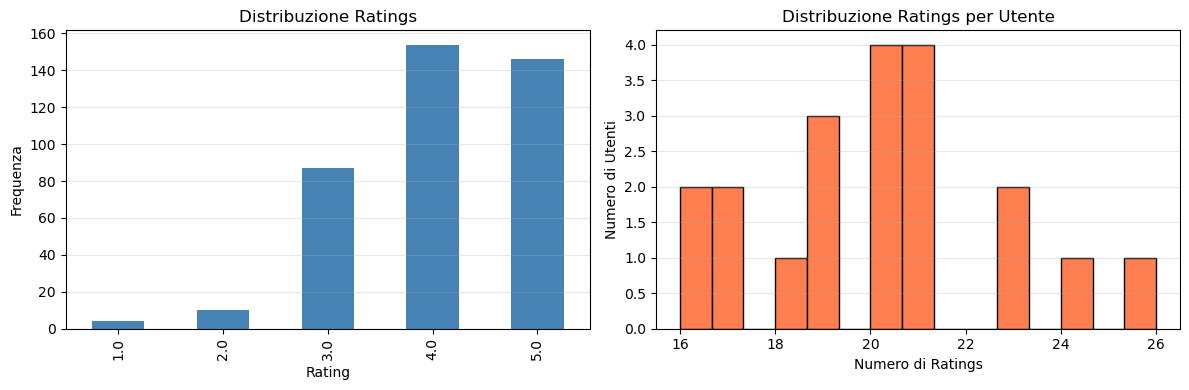

Sparsity: 77.0%


In [5]:
# Distribuzione dei ratings
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribuzione ratings
df['rating'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Distribuzione Ratings')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequenza')
axes[0].grid(axis='y', alpha=0.3)

# Ratings per utente
ratings_per_user = df.groupby('user_id').size()
axes[1].hist(ratings_per_user, bins=15, color='coral', edgecolor='black')
axes[1].set_title('Distribuzione Ratings per Utente')
axes[1].set_xlabel('Numero di Ratings')
axes[1].set_ylabel('Numero di Utenti')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Sparsity: {(1 - len(df) / (df['user_id'].nunique() * df['item_id'].nunique())) * 100:.1f}%")

## [4] Test delle Funzioni MCP Server

Importiamo e testiamo le funzioni del server MCP direttamente.

In [6]:
# Import delle funzioni dal server MCP
from recommender_server import (
    load_or_initialize_data,
    get_recommendations,
    add_rating,
    get_similar_users,
    get_user_stats
)

# Inizializza i dati
load_or_initialize_data()
print("Server MCP inizializzato")

Loaded 401 ratings from c:\Users\Patrick\Desktop\Progetto Recommender Systems\data\ratings.csv
Loaded 103 movies from c:\Users\Patrick\Desktop\Progetto Recommender Systems\data\movies.csv


Server MCP inizializzato


### 4.1 - Statistiche Utente

In [7]:
# Test: Ottieni statistiche per un utente
user_id = 5

result = await get_user_stats(user_id=user_id)
stats = eval(result)  # Converti stringa a dict

print(f"Statistiche Utente {user_id}:")
print(f"   Total ratings: {stats['total_ratings']}")
print(f"   Average rating: {stats['average_rating']:.2f}")
print(f"   Min rating: {stats['min_rating']}")
print(f"   Max rating: {stats['max_rating']}")
print(f"   Rated items: {stats['rated_items']}")

Statistiche Utente 5:
   Total ratings: 24
   Average rating: 3.92
   Min rating: 2.0
   Max rating: 5.0
   Rated items: [120, 134, 115, 118, 112, 109, 121, 116, 110, 122, 113, 102, 130, 128, 133, 114, 117, 125, 135, 108, 105, 127, 106, 101]


### 4.2 - Utenti Simili

In [9]:
user=17
# Test: Trova utenti simili
result = await get_similar_users(user_id=user, top_n=5)
similar = eval(result)

print(f"[SIMILARITY] Utenti simili a User {similar['user_id']}:\n")
for sim_user in similar['similar_users']:
    print(f"   User {sim_user['user_id']}: similarity = {sim_user['similarity_score']:.4f}")

[SIMILARITY] Utenti simili a User 17:

   User 8: similarity = 0.7887
   User 19: similarity = 0.6105
   User 20: similarity = 0.5900
   User 18: similarity = 0.3723
   User 15: similarity = 0.3722


### 4.3 - Raccomandazioni (Collaborative Filtering)

In [10]:
user=1
# Test: Ottieni raccomandazioni
result = await get_recommendations(user_id=user, top_n=5)
recommendations = eval(result)

print(f"[RECOMMENDATIONS] Raccomandazioni per User {recommendations['user_id']}:\n")
for rec in recommendations['recommendations']:
    print(f"   Item {rec['item_id']}: predicted rating = {rec['predicted_rating']:.2f}")

[RECOMMENDATIONS] Raccomandazioni per User 1:

   Item 133: predicted rating = 5.00
   Item 139: predicted rating = 5.00
   Item 148: predicted rating = 4.89
   Item 130: predicted rating = 4.76
   Item 152: predicted rating = 4.60


### 4.4 - Aggiungi Nuovo Rating

In [14]:
user=3
item_id=105
rating=2

# Test: Aggiungi un nuovo rating
result = await add_rating(user_id=user, item_id=item_id, rating=rating)
print(result)

# Verifica le nuove raccomandazioni
result = await get_recommendations(user_id=2, top_n=3)
new_recommendations = eval(result)

print(f"\n Nuove raccomandazioni dopo il rating:")
for rec in new_recommendations['recommendations']:
    print(f"   Item {rec['item_id']}: predicted rating = {rec['predicted_rating']:.2f}")

Updated rating: User 3 rated Item 105 as 2


Updated rating: User 3 rated Item 105 as 2

 Nuove raccomandazioni dopo il rating:
   Item 146: predicted rating = 4.59
   Item 136: predicted rating = 4.56
   Item 111: predicted rating = 4.55


## [5] Analisi Algoritmo Collaborative Filtering

### Come Funziona:

1. **Calcolo Similarity**: Pearson similarity tra utenti basata su item in comune
2. **Weighted Average**: Rating predetto = media pesata dei rating degli utenti simili
3. **Formula**: 
   $$\hat{r}_{u,i} = \frac{\sum_{v \in N(u)} sim(u,v) \cdot r_{v,i}}{\sum_{v \in N(u)} sim(u,v)}$$

Dove:
- $\hat{r}_{u,i}$ = rating predetto per utente $u$ e item $i$
- $sim(u,v)$ = Pearson similarity tra utenti $u$ e $v$
- $r_{v,i}$ = rating dell'utente $v$ per item $i$
- $N(u)$ = insieme di utenti simili a $u$

In [11]:
# Ricarica il dataset aggiornato dopo add_rating
df = pd.read_csv(data_path)

# Visualizziamo la matrice user-item (parziale)
user_item_matrix = df.pivot_table(
    index='user_id',
    columns='item_id',
    values='rating'
)

# Mostra porzione della matrice per i primi 5 utenti e 10 item
print("[MATRIX] User-Item Matrix (parziale):")
print(user_item_matrix.iloc[:5, :10].fillna('-'))


[MATRIX] User-Item Matrix (parziale):
item_id  101  102  103  104  105  106  107  108  109  110
user_id                                                  
1          -  3.0    -  5.0  4.0  5.0    -  4.0  3.0  4.0
2        5.0  5.0  5.0  3.0  5.0  5.0    -  5.0  4.0    -
3        4.0  4.0  3.0    -  2.0    -  4.0  5.0  5.0  5.0
4          -    -    -  4.0  4.0    -    -    -  5.0    -
5        4.0  5.0    -    -  2.0  3.0    -  4.0  4.0  3.0
